# ACCESS-S2-EKE-example

**Date:** <br>
2 August 2021 <br>
**Background:** <br>
A quick example of how to calculate EKE from ACCESS-S2 reanalysis(RA)<br>
**Author(s):**<br>
Thomas Moore<br>

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import numpy as np
import xrft
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
%config Completer.use_jedi = False

In [3]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# Spin up cluster with `dask-jobqueue` 
*this is only large to run the pre-process load, rechunk, and write steps*<br>
see steps to skip below

### Specs for an individual worker

In [4]:
walltime = '02:00:00'
cores = 48
memory = '192GB'

cluster = PBSCluster(processes = 1, walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/v14+scratch/v14+gdata/lp01+scratch/lp01+scratch/ux06+gdata/rr3+gdata/al33+gdata/zv2+gdata/ux62'],
                     header_skip=["select"])

### Scale up to n workers

In [5]:
cluster.scale(jobs=8)

In [6]:
client = Client(cluster)

In [8]:
client

Client Scheduler: tcp://10.6.67.43:41173 Dashboard: http://10.6.67.43:8787/status,Cluster Workers: 8 Cores: 384 Memory: 1.40 TiB


# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip arrows if you can
# $\Downarrow$

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

# load U & V S2_RA

In [8]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_u_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_u_1981_2018

CPU times: user 3.91 s, sys: 1.24 s, total: 5.16 s
Wall time: 20.2 s


<xarray.Dataset>
Dimensions:            (depthu: 75, tbnds: 2, time_counter: 456, x: 1442, y: 1021)
Coordinates:
  * depthu             (depthu) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: tbnds, x, y
Data variables:
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    u                  (time_counter, depthu, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

In [9]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_v_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_v_1981_2018

CPU times: user 3.8 s, sys: 1.21 s, total: 5.01 s
Wall time: 19.1 s


<xarray.Dataset>
Dimensions:            (depthv: 75, tbnds: 2, time_counter: 456, x: 1442, y: 1021)
Coordinates:
  * depthv             (depthv) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: tbnds, x, y
Data variables:
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    v                  (time_counter, depthv, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:34 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:08:10 2019: ncatted -a history,global,d,, mo_...

# Deal with the same depth coordinates given two different names & rename time

In [10]:
ds_u_1981_2018 = ds_u_1981_2018.rename({'depthu':'depth','time_counter':'time'})
ds_v_1981_2018 = ds_v_1981_2018.rename({'depthv':'depth','time_counter':'time'})

# rechunk the data to shrink chunks from 5GB to 100MB
**could use `rechunker` here?**

In [11]:
u = ds_u_1981_2018.chunk({'time':456,'depth':1,'x':250,'y':250})
v = ds_v_1981_2018.chunk({'time':456,'depth':1,'x':250,'y':250})

# write U & V to zarr collections

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.zarr
u.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.zarr',consolidated=True)

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.zarr
v.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.zarr',consolidated=True)

# $\Downarrow$
# CAN SKIP TO THIS STEP IF U & V `ZARR` FILES ARE WRITTEN AND AVAILABLE
hard part for u & v done above

In [16]:
u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.zarr',consolidated=True)
v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.zarr',consolidated=True)

In [17]:
def calc_EKE(u, v, time_name = 'time'):
    '''
    Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}
    u,v are x and y currents as an xarray data array
    '''
    u_mean = u.mean(time_name)
    v_mean = v.mean(time_name)
    MKE = 0.5*(u_mean**2 + v_mean**2).rename('MKE') # currents
    EKE = ( 0.5 * ((u-u_mean)**2 + (v-v_mean)**2) ).rename('EKE') # eddies
    return EKE, MKE

In [18]:
u_da = u.u
v_da = v.v

In [19]:
%%time
[EKE, MKE] = calc_EKE(u_da, v_da, time_name='time')

CPU times: user 290 ms, sys: 12.5 ms, total: 302 ms
Wall time: 634 ms


In [20]:
KE = xr.merge([EKE,MKE])

In [21]:
KE

,Array,Chunk
Bytes,187.16 GiB,108.48 MiB
Shape,"(455, 75, 1021, 1442)","(455, 1, 250, 250)"
Count,36002 Tasks,2250 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,421.22 MiB,244.14 kiB
Shape,"(75, 1021, 1442)","(1, 250, 250)"
Count,22502 Tasks,2250 Chunks
Type,float32,numpy.ndarray


In [46]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr
KE.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr',consolidated=True)

CPU times: user 46.5 s, sys: 2.4 s, total: 48.9 s
Wall time: 2min 4s


# $\Downarrow$
# CAN SKIP TO THIS STEP IF EKE `ZARR` FILE IS WRITTEN AND AVAILABLE
hard part for u & v & EKE & MKE done above

In [9]:
KE = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr',consolidated=True)

In [10]:
EKE_mean = KE.EKE.mean('time').compute()

# reduce dataset to surface only

In [17]:
KE_surface = KE.isel(depth=0).compute()

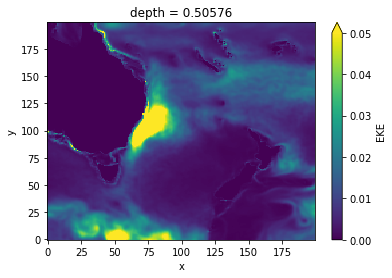

In [20]:
KE_surface.sel(x=slice(250,450),y=slice(250,450)).mean('time').EKE.plot(vmax=.05)

# write file to netcdf

In [21]:
%%time
KE_surface.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE_surface.nc',mode='w')

CPU times: user 99.7 ms, sys: 1.82 s, total: 1.92 s
Wall time: 3.3 s


In [22]:
KE = KE.persist()

In [ ]:
%%time
KE.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nc',mode='w')

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [13]:
client.restart()

Client Scheduler: tcp://10.6.79.72:34869 Dashboard: http://10.6.79.72:8787/status,Cluster Workers: 32 Cores: 384 Memory: 1.40 TiB
